# Adding expression data and visualizig a network                       

Applications that were used: Cytoscape (v.3.8.2) and Jupyter Notebooks (v.2.2.6) through the Anaconda navigator (v.1.10.0).

In Cytoscape, the following app was installed: FileTransfer (v.1.1) for communication to Jupyter notebooks. 
To install apps in Cytoscape go to Apps -> App Manager -> Search

For those new to working with Jupyter Notebooks, go to the [MarkDown Tutorial](https://www.markdowntutorial.com/lesson/1/) to learn how to comment your code properly. 

Now let's move on to the code. 

# Loading expression data

We start with loading the required packages for this code. 

### Step 1: Importing required packages

In [1]:
import os
import sys
import requests
import pandas as pd
import py4cytoscape as p4c
from lxml import etree as ET

Check py4cytoscape version

In [2]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.8.2',
 'automationAPIVersion': '1.1.0',
 'py4cytoscapeVersion': '0.0.8'}

## Step 2: Loading an existing network

We are using a previously created network in .cys format. First we will define a new variable to the file path and then a new variable to the path+file name. You can also import files of different formats, such as the .sif format. Look into py4cytoscape documentation on how to import different file types. 

In [26]:
path = 'C:/Users/stefa/Documents/GitHub/2021-internship/Raats/'
file_name = path + 'doubleCytargeted.cys'
file_name

'C:/Users/stefa/Documents/GitHub/2021-internship/Raats/doubleCytargeted.cys'

Now we will load this network in cytoscape

In [27]:
abs_file_name = os.path.abspath(file_name)

In [28]:
session_cmd_list = ['session','open','file="',abs_file_name,'"']
session_cmd = " ".join(session_cmd_list)

In [29]:
p4c.commands.commands_run(session_cmd)

[]

## Step 3: Loading Expression Data
Great! Our network is loaded. Now we will move on to loading the expression data.  
First we will define the path of our expression data file. Next, we will define a new dataframe with the information in our expression data file. To check whether it was loaded correctly, we view the first 5 rows using df.head()

In [30]:
expression_file = path + 'expDatafile.csv'
df=pd.read_csv(expression_file)
df.head()

,Unnamed: 0,logFC,logCPM,F,PValue,FDR
0,SAA2,2.414265,5.432500,512.091071,1.406545e-12,1.877738e-08
1,CCL20,3.133684,4.949061,447.918174,3.560546e-12,2.376665e-08
2,IL36G,2.722310,4.359048,340.454929,2.359692e-11,1.050063e-07
3,INHBA,1.810556,6.511435,272.793242,1.071872e-10,3.577374e-07
4,TNFAIP3,1.601914,7.418585,263.426641,1.358966e-10,3.628440e-07


Now lets load the data into our network. You need to set the Key column to indicate which column will be used to match with the network column. I want the values to be matched to their corresponding genes. Therefore I choose the first column as the key column. The program will look in our network for the corresponding gene name and then assign the other values to the same row.


In [31]:
p4c.load_table_data(df, data_key_column="Unnamed: 0")

C:\Users\stefa\anaconda3\lib\site-packages\py4cytoscape\tables.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[col] = col_val


'Success: Data loaded in defaultnode table'

# Visualizing the network  
Now we will start visualizing the network. First, I wish to know my column names so I do not make any mistakes further in the code. 

In [32]:
p4c.tables.get_table_column_names('node')

['SUID',
 'shared name',
 'name',
 'selected',
 'GraphID',
 'Type',
 'XrefId',
 'XrefDatasource',
 'Color',
 'Border Width',
 'Node Size',
 'Label Font Size',
 'Ensembl',
 'CTL.Ext',
 'CTL.Type',
 'CTL.PathwayName',
 'CTL.label',
 'CTL.PathwayID',
 'CTL.GeneName',
 'CTL.GeneID',
 'Unnamed: 0',
 'logFC',
 'logCPM',
 'F',
 'PValue',
 'FDR']

## Step 1: LogFC gradient  

Now we will apply a gradient to my nodes using the LogFC values. Overexpressed nodes will be red, and underexpressed will be blue. If a node's LogFC value is close to 0, there should be almost no colour. 

In [33]:
exp_score_table = p4c.tables.get_table_columns('node', 'logFC')
exp_min = min(exp_score_table['logFC'])
exp_max = max(exp_score_table['logFC'])
print(exp_min)
print(exp_max)

-1.6662939468468898
4.79871351926883


### Applying the colour gradient.  
Now I will apply new colours to my code. 
The format for the code is:  

p4c.set_node_color_mapping(table_column, table_column_values=None, colors=None, mapping_type='c', default_color=None, style_name=None, network=None)
You can modify which colours and style you want to change, as well as whether the mapping is continous 'c', discrete 'd' or pasthrough 'p'


In [34]:
p4c.set_node_color_mapping('logFC', table_column_values=[exp_min, exp_max], colors=['#0000FF', '#FF0000'], style_name='CyTargetLinker_0')

''

Note that  in the previous command we have specified the name of our style. If you leave this blank, it will update the default style only. See the output in the image below

This file already exists. A Cytoscape popup will be generated to confirm overwrite.


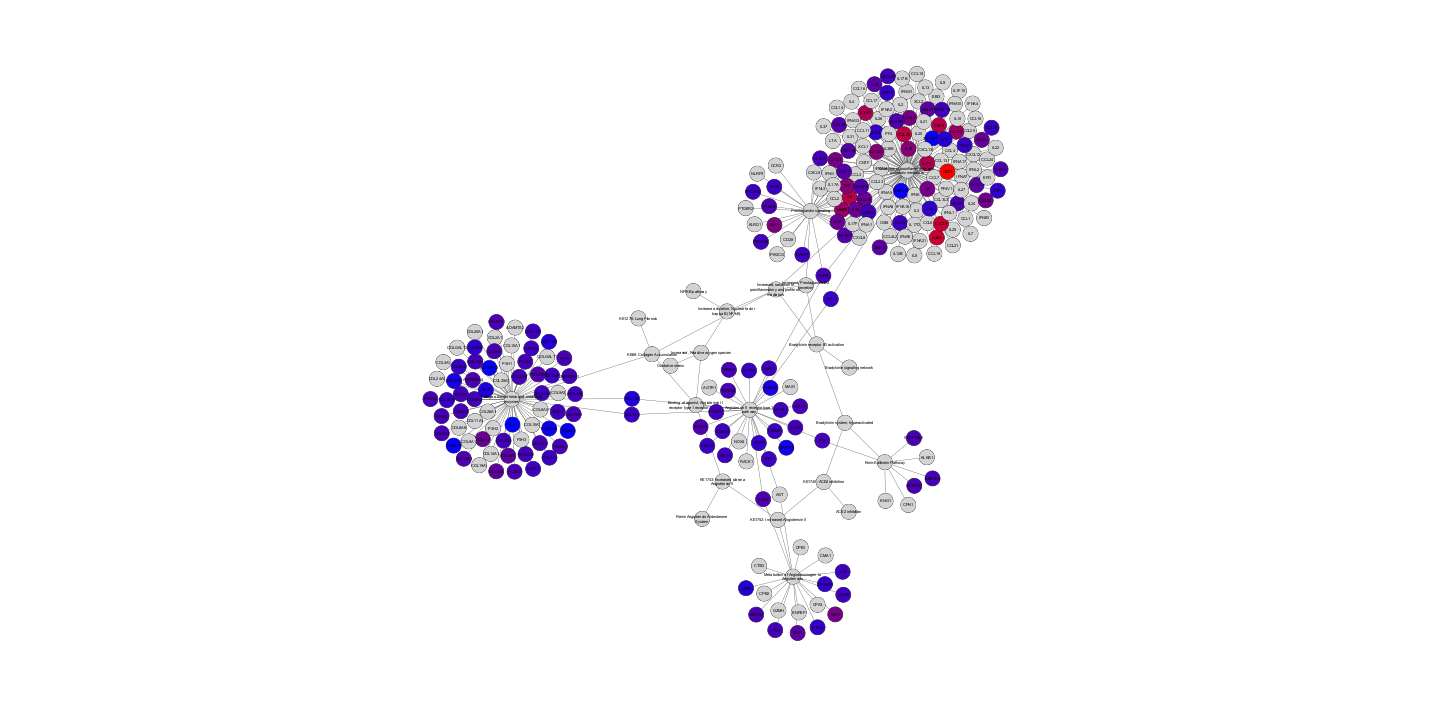

In [35]:
p4c.export_image(filename='expNetwork.png')
p4c.sandbox_get_from('expNetwork.png')
from IPython.display import Image
Image('expNetwork.png')

## Step 2a: Adding p-value annotation: gradient border
Now we want to do the same thing, but using our P-value. Ofcourse we can not change the colour of our nodes again. This time we will use the border thickness. I want nodes with a low p-value to have a thick border, so I can easily spot them. High p-values will have a thin border. It is recommended to keep the border thin overall, so you can still see the gene name.

In [36]:
sig_score_table = p4c.get_table_columns(table='node', columns='PValue')
sig_min = sig_score_table.min().values[0]
sig_max = sig_score_table.max().values[0]
p4c.set_node_border_width_mapping('PValue', table_column_values=[sig_min, sig_max], widths=[20, 5], style_name='CyTargetLinker_0')

''

Let's view our output. 

This file already exists. A Cytoscape popup will be generated to confirm overwrite.


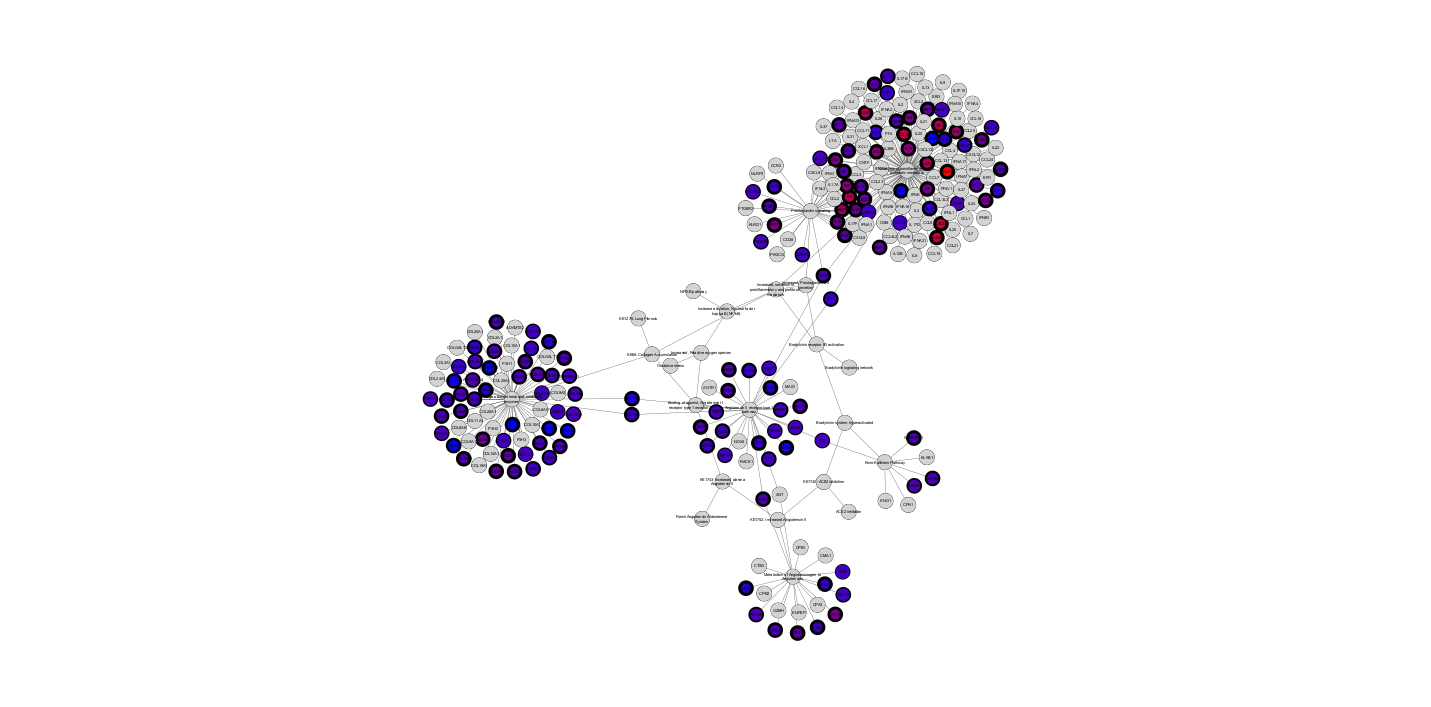

In [37]:
p4c.export_image(filename='sig.png')
p4c.sandbox_get_from('sig.png')
from IPython.display import Image
Image('sig.png')

## Step 2b: Adding p-value colouring: cut-off
However, usually you are only interested in genes that have a significance of p<0.05. Let's write something for that. I want a small green ring around genes that are significant and a black ring around genes that are not. 
First let us make all the borders the same width.

In [52]:
p4c.set_node_border_width_mapping('PValue', table_column_values=[sig_min, sig_max], widths=[5, 5], style_name='CyTargetLinker_0')
#p4c.set_node_border_width_default(5, style_name='CyTargetLinker_0')

''

Now I want a list of all my significant genes. I do this by using the create column filter code. First I give the name, then the corresponding column and it's value and then the condition. In this case, "LESS_THAN". 

In [43]:
sig_gene_list = p4c.create_column_filter('sig_gene_list','PValue', 0.05, "LESS_THAN")

Warning -- Cytoscape version pre-3.9 in use ... settling delay inserted after filter execution


No edges selected.


In [44]:
sig_gene_list

{'nodes': ['IL1RN',
  'IL36A',
  'TNF',
  'CXCL10',
  'MMP9',
  'IL23A',
  'CXCL1',
  'CCL28',
  'CCL20',
  'MMP1',
  'CSF2',
  'CXCL3',
  'CXCL6',
  'CSF1',
  'CSF3',
  'IL15',
  'LIF',
  'VEGFA',
  'IL33',
  'CXCL14',
  'CXCL2',
  'CTGF',
  'CXCL5',
  'NFKB1',
  'MAP2K6',
  'IL36G',
  'IL6',
  'SMAD3',
  'IL1B',
  'IL1A',
  'TGFBR2',
  'IL17C',
  'CXCL16',
  'PTGES',
  'IRF7',
  'TLL2',
  'COL8A1',
  'TLL1',
  'ATP6AP2',
  'MME',
  'CES1',
  'COL12A1',
  'PPIB'],
 'edges': None}

### Great! But, unfortunately we can not use this list directly to change our code. Therefore we must make a dataframe and then extract a column list. 

In [45]:
dfSigGene = pd.DataFrame(sig_gene_list)
dfSigGene.head()

,nodes,edges
0,IL1RN,None
1,IL36A,None
2,TNF,None
3,CXCL10,None
4,MMP9,None


In [46]:
col_one_list = dfSigGene['nodes'].tolist()
print(f"\ncol_one_list:\n{col_one_list}\ntype:{type(col_one_list)}")



col_one_list:
['IL1RN', 'IL36A', 'TNF', 'CXCL10', 'MMP9', 'IL23A', 'CXCL1', 'CCL28', 'CCL20', 'MMP1', 'CSF2', 'CXCL3', 'CXCL6', 'CSF1', 'CSF3', 'IL15', 'LIF', 'VEGFA', 'IL33', 'CXCL14', 'CXCL2', 'CTGF', 'CXCL5', 'NFKB1', 'MAP2K6', 'IL36G', 'IL6', 'SMAD3', 'IL1B', 'IL1A', 'TGFBR2', 'IL17C', 'CXCL16', 'PTGES', 'IRF7', 'TLL2', 'COL8A1', 'TLL1', 'ATP6AP2', 'MME', 'CES1', 'COL12A1', 'PPIB']
type:<class 'list'>


Now let us set our green colour and apply it to the border of these genes. To make it easier to view, I also enlarge the border with. 

In [53]:
p4c.set_node_border_color_bypass(col_one_list, '#00FF00')
p4c.set_node_border_width_bypass(col_one_list, 10)

''

This file already exists. A Cytoscape popup will be generated to confirm overwrite.


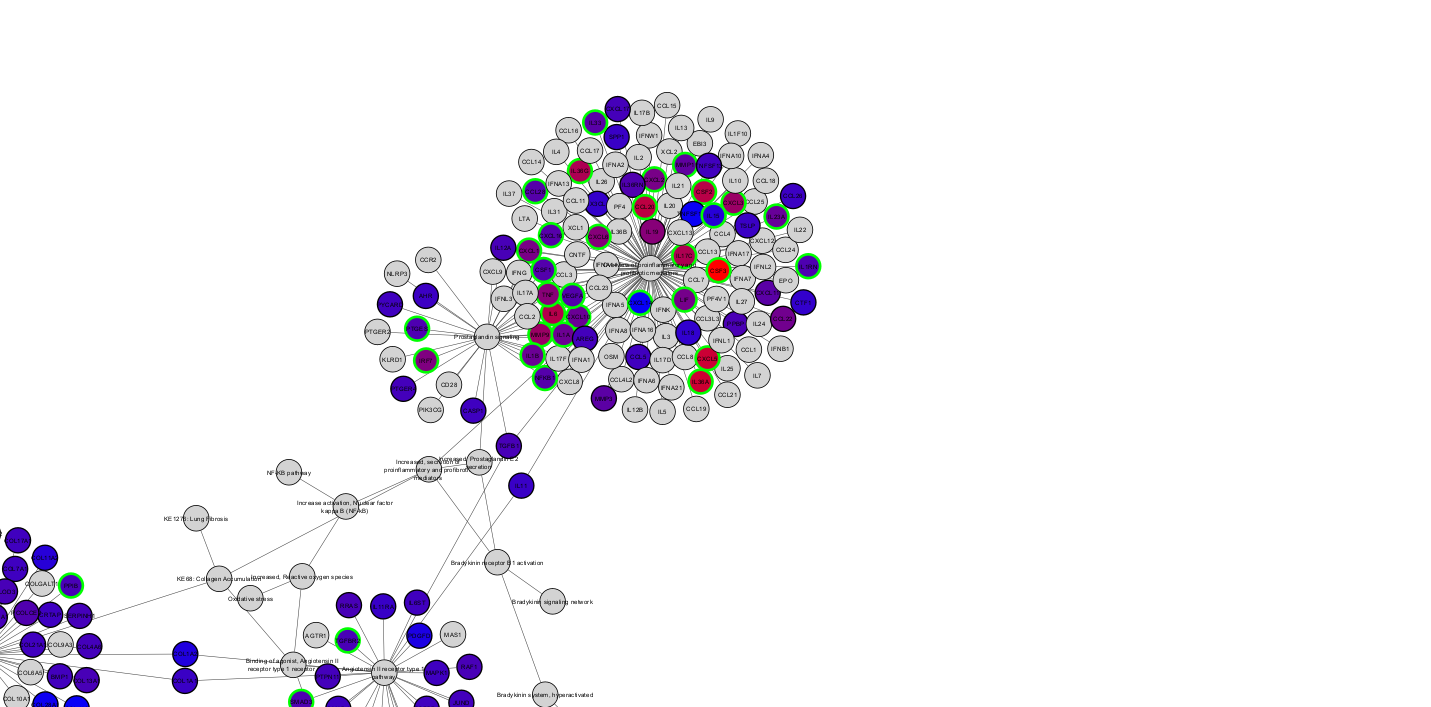

In [54]:
p4c.export_image(filename='sigGreen.png')
p4c.sandbox_get_from('sigGreen.png')
from IPython.display import Image
Image('sigGreen.png')